In [1]:
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa
import librosa.display

In [2]:
filename='data/UrbanSound8K/audio/fold1/7061-6-0-0.wav'

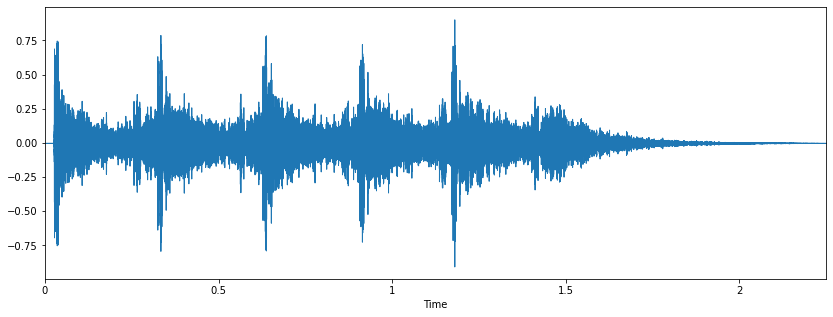

In [3]:
plt.figure(figsize=(14,5))
librosa_audio_data,librosa_sample_rate=librosa.load(filename)
librosa.display.waveplot(librosa_audio_data,sr=librosa_sample_rate)
ipd.Audio(filename)

In [4]:
from scipy.io import wavfile as wav

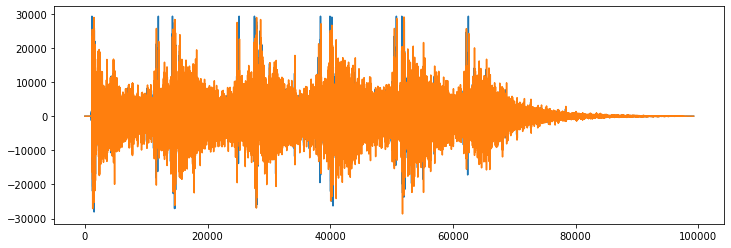

In [5]:
wave_sample_rate, wave_audio = wav.read(filename)

# Original audio with 2 channels 
plt.figure(figsize=(12, 4))
plt.plot(wave_audio)

# Extract feature

In [6]:
import pandas as pd

audio_dataset_path='data/UrbanSound8K/audio/'
metadata=pd.read_csv('data/UrbanSound8K/metadata/UrbanSound8K.csv')
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [7]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

In [10]:
import numpy as np
from tqdm import tqdm
import os

### Now we iterate through every audio file and extract features 
### using Mel-Frequency Cepstral Coefficients
extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    data=features_extractor(file_name)
    extracted_features.append([data,"noise"])

noiseLength = len(extracted_features)
count = 0
for i in os.listdir(os.path.join("data", "clean_train")):
    file_name = os.path.join("data", "clean_train", i)
    data=features_extractor(file_name)
    extracted_features.append([data,"clean"])
    count+=1
    if (count >= noiseLength):
        break

8732it [05:31, 26.36it/s]


In [11]:
### converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
len(extracted_features_df)

17464

In [12]:
extracted_features_df = extracted_features_df.sample(frac=1).reset_index(drop=True)
extracted_features_df.head()

,feature,class
0,"[-352.10345, 119.42653, -25.888117, 52.71784, ...",clean
1,"[-286.7915, 150.86234, -81.95369, 45.09411, -1...",noise
2,"[-324.77972, 157.57205, -20.671232, 33.487118,...",clean
3,"[-304.68192, 139.30627, -21.297682, 49.280373,...",clean
4,"[-48.17052, 139.137, -42.80236, 45.565357, -25...",noise


In [13]:
clean_class = extracted_features_df[extracted_features_df['class'] == 'clean']
len(clean_class)

8732

In [14]:
noise_class = extracted_features_df[extracted_features_df['class'] == 'noise']
len(noise_class)

8732

# Data split

In [15]:
### Split the dataset into independent and dependent dataset
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [16]:
y=np.array(pd.get_dummies(y))

In [17]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [18]:
y_train[:10]

array([[0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1]], dtype=uint8)

# Tensorflow

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [20]:
num_labels=y.shape[1]

In [21]:
model=Sequential()

###first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4100      
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               20200     
                                                                 
 activation_1 (Activation)   (None, 200)               0         
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               2

In [22]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [23]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint

num_epochs = 10
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/noise_classification.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)

Epoch 1/10
434/437 [============================>.] - ETA: 0s - loss: 2.7651 - accuracy: 0.7941
Epoch 1: val_loss improved from inf to 0.11153, saving model to saved_models\noise_classification.hdf5
437/437 [==============================] - 5s 7ms/step - loss: 2.7498 - accuracy: 0.7950 - val_loss: 0.1115 - val_accuracy: 0.9911
Epoch 2/10
432/437 [============================>.] - ETA: 0s - loss: 0.1763 - accuracy: 0.9512
Epoch 2: val_loss improved from 0.11153 to 0.02813, saving model to saved_models\noise_classification.hdf5
437/437 [==============================] - 3s 6ms/step - loss: 0.1753 - accuracy: 0.9515 - val_loss: 0.0281 - val_accuracy: 0.9966
Epoch 3/10
431/437 [============================>.] - ETA: 0s - loss: 0.0618 - accuracy: 0.9825
Epoch 3: val_loss improved from 0.02813 to 0.00949, saving model to saved_models\noise_classification.hdf5
437/437 [==============================] - 3s 6ms/step - loss: 0.0613 - accuracy: 0.9827 - val_loss: 0.0095 - val_accuracy: 0.9977
Ep

In [24]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.9994274377822876


In [33]:
noisefile = "data/noise_train/AirConditioner_5.wav"
prediction_feature=features_extractor(noisefile)
prediction_feature=prediction_feature.reshape(1,-1)
predict_x= (model.predict(prediction_feature) > 0.8).astype("int32")
print(predict_x)
ipd.Audio(noisefile)

1/1 [==============================] - 0s 15ms/step
[[1 0]]


In [32]:
cleanfile = "data/clean_test/clnsp6.wav"
prediction_feature=features_extractor(cleanfile)
prediction_feature=prediction_feature.reshape(1,-1)
predict_x= (model.predict(prediction_feature) > 0.8).astype("int32")
print(predict_x)
ipd.Audio(cleanfile)

1/1 [==============================] - 0s 15ms/step
[[1 0]]
